# Analysis of Yelp Business Intelligence Data
We will analyze a subset of Yelp's business, reviews and user data. This dataset comes to us from [Kaggle](https://www.kaggle.com/yelp-dataset/yelp-dataset) although we have taken steps to pull this data into a public s3 bucket: `s3://sta9760-yelpdataset/yelp-light/*business.json`

# Installation and Initial Setup
Begin by installing the necessary libraries that you may need to conduct your analysis. At the very least, you must install `pandas` and `matplotlib`

In [1]:
sc.install_pypi_package("pandas==1.0.3")
sc.install_pypi_package("matplotlib==3.2.1")
sc.list_packages()

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
0,application_1637717402085_0001,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…



Package                    Version  
-------------------------- ---------
beautifulsoup4             4.9.1    
boto                       2.49.0   
click                      7.1.2    
cycler                     0.11.0   
jmespath                   0.10.0   
joblib                     0.16.0   
kiwisolver                 1.3.2    
lxml                       4.5.2    
matplotlib                 3.2.1    
mysqlclient                1.4.2    
nltk                       3.5      
nose                       1.3.4    
numpy                      1.16.5   
pandas                     1.0.3    
pip                        9.0.1    
py-dateutil                2.2      
pyparsing                  3.0.6    
python-dateutil            2.8.2    
python37-sagemaker-pyspark 1.4.0    
pytz                       2020.1   
PyYAML                     5.3.1    
regex                      2020.7.14
setuptools                 28.8.0   
six                        1.13.0   
soupsieve                  1.9.5    

## Importing
Now, import the installed packages from the previous block below.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Loading Data
We are finally ready to load data. Using `spark` load the data from S3 into a `dataframe` object that we can manipulate further down in our analysis.

In [4]:
df_business = spark.read.json("s3://sta9760f2021bena-spark-datasets/yelp_academic_dataset_business.json")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Overview of Data
Display the number of rows and columns in our dataset.

In [5]:
print(f'Total Columns: {len(df_business.dtypes)}' " | " f'Total Rows: {df_business.count():,}')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Total Columns: 14 | Total Rows: 160,585

Display the DataFrame schema below.

In [6]:
df_business.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- address: string (nullable = true)
 |-- attributes: struct (nullable = true)
 |    |-- AcceptsInsurance: string (nullable = true)
 |    |-- AgesAllowed: string (nullable = true)
 |    |-- Alcohol: string (nullable = true)
 |    |-- Ambience: string (nullable = true)
 |    |-- BYOB: string (nullable = true)
 |    |-- BYOBCorkage: string (nullable = true)
 |    |-- BestNights: string (nullable = true)
 |    |-- BikeParking: string (nullable = true)
 |    |-- BusinessAcceptsBitcoin: string (nullable = true)
 |    |-- BusinessAcceptsCreditCards: string (nullable = true)
 |    |-- BusinessParking: string (nullable = true)
 |    |-- ByAppointmentOnly: string (nullable = true)
 |    |-- Caters: string (nullable = true)
 |    |-- CoatCheck: string (nullable = true)
 |    |-- Corkage: string (nullable = true)
 |    |-- DietaryRestrictions: string (nullable = true)
 |    |-- DogsAllowed: string (nullable = true)
 |    |-- DriveThru: string (nullable = true)
 |    |-- GoodForDancing: str

Display the first 5 rows with the following columns:

* `business_id`
* `name`
* `city`
* `state`
* `categories`

In [7]:
df_business.select('business_id', 'name', 'city', 'state', 'categories').show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+-----------+-----+--------------------+
|         business_id|                name|       city|state|          categories|
+--------------------+--------------------+-----------+-----+--------------------+
|6iYb2HFDywm3zjuRg...| Oskar Blues Taproom|    Boulder|   CO|Gastropubs, Food,...|
|tCbdrRPZA0oiIYSmH...|Flying Elephants ...|   Portland|   OR|Salad, Soup, Sand...|
|bvN78flM8NLprQ1a1...|      The Reclaimory|   Portland|   OR|Antiques, Fashion...|
|oaepsyvc0J17qwi8c...|         Great Clips|Orange City|   FL|Beauty & Spas, Ha...|
|PE9uqAjdw0E4-8mjG...|   Crossfit Terminus|    Atlanta|   GA|Gyms, Active Life...|
+--------------------+--------------------+-----------+-----+--------------------+
only showing top 5 rows

# Analyzing Categories
Let's now answer this question: **how many unique categories are represented in this dataset?**

Essentially, we have the categories per business as a list - this is useful to quickly see what each business might be represented as but it is difficult to easily answer questions such as:

* How many businesses are categorized as `Active Life`, for instance
* What are the top 20 most popular categories available?

## Association Table

We need to "break out" these categories from the business ids? One common approach to take is to build an association table mapping a single business id multiple times to each distinct category.

For instance, given the following:


| business_id | categories |
|-------------|------------|
| abcd123     | a,b,c      |

We would like to derive something like:

| business_id | category |
|-------------|------------|
| abcd123     | a          |
| abcd123     | b          |
| abcd123     | c          |


What this does is allow us to then perform a myriad of rollups and other analysis on this association table which can aid us in answering the questions asked above.

Implement the code necessary to derive the table described from your original yelp dataframe.

Display the first 5 rows of your association table below.

In [8]:
from pyspark.sql.functions import explode, split

df_business_exploded = df_business.withColumn("categories", explode(split("categories",",")))
df_business_exploded.select('business_id', 'categories').show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-------------+
|         business_id|   categories|
+--------------------+-------------+
|6iYb2HFDywm3zjuRg...|   Gastropubs|
|6iYb2HFDywm3zjuRg...|         Food|
|6iYb2HFDywm3zjuRg...| Beer Gardens|
|6iYb2HFDywm3zjuRg...|  Restaurants|
|6iYb2HFDywm3zjuRg...|         Bars|
+--------------------+-------------+
only showing top 5 rows

## Total Unique Categories

Finally, we are ready to answer the question: **what is the total number of unique categories available?**

Below, implement the code necessary to calculate this figure.

In [10]:
df_business_exploded.select('categories').distinct().count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

2487

## Top Categories By Business

Now let's find the top categories in this dataset by rolling up categories.

### Counts of Businesses / Category

So now, let's unroll our distinct count a bit and display the per count value of businesses per category.

The expected output should be:

| category | count |
|-------------|------------|
| a     | 15         |
| b     | 2          |
| c     | 45          |

Or something to that effect.

In [11]:
business_grouped = df_business_exploded.groupby('categories')
business_grouped.count().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+
|          categories|count|
+--------------------+-----+
|      Dermatologists|   68|
|      Paddleboarding|   12|
|               Tires| 1456|
|    Historical Tours|   60|
|               Hakka|    4|
|         Hobby Shops|  135|
|    Military Surplus|   11|
| Food Safety Trai...|    2|
|          Bubble Tea|  184|
|             Embassy|    3|
|            Handyman|   87|
|            Macarons|   50|
|             Propane|   83|
|             Tanning|  147|
|  Convenience Stores| 1340|
|            Japanese| 2039|
|         Car Dealers| 1013|
|             Lawyers|  422|
|             Rolfing|   28|
|        IV Hydration|   47|
+--------------------+-----+
only showing top 20 rows

### Bar Chart of Top Categories

With this data available, let us now build a barchart of the top 20 categories. 

**HINT**: don't forget about the matplotlib magic!

```
%matplot plt
```

In [12]:
barchart_df = business_grouped.count().orderBy('count',ascending=False)
barchart_df.show(20)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+
|          categories|count|
+--------------------+-----+
|         Restaurants|36340|
|                Food|22094|
|            Shopping|20056|
|         Restaurants|14423|
|       Home Services|12001|
|       Beauty & Spas|11633|
|    Health & Medical|11390|
|           Nightlife| 9808|
|      Local Services| 9299|
|                Bars| 8914|
| Event Planning &...| 7617|
|                Food| 7375|
|         Active Life| 7039|
|          Automotive| 6785|
|            Shopping| 6149|
|        Coffee & Tea| 5735|
|          Sandwiches| 5697|
| American (Tradit...| 5235|
|             Fashion| 5231|
|       Beauty & Spas| 4941|
+--------------------+-----+
only showing top 20 rows

In [13]:
pdf = barchart_df.toPandas()
pdf_top20 = pdf.head(20)
pdf_top20

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

                    categories  count
0                  Restaurants  36340
1                         Food  22094
2                     Shopping  20056
3                  Restaurants  14423
4                Home Services  12001
5                Beauty & Spas  11633
6             Health & Medical  11390
7                    Nightlife   9808
8               Local Services   9299
9                         Bars   8914
10   Event Planning & Services   7617
11                        Food   7375
12                 Active Life   7039
13                  Automotive   6785
14                    Shopping   6149
15                Coffee & Tea   5735
16                  Sandwiches   5697
17      American (Traditional)   5235
18                     Fashion   5231
19               Beauty & Spas   4941

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

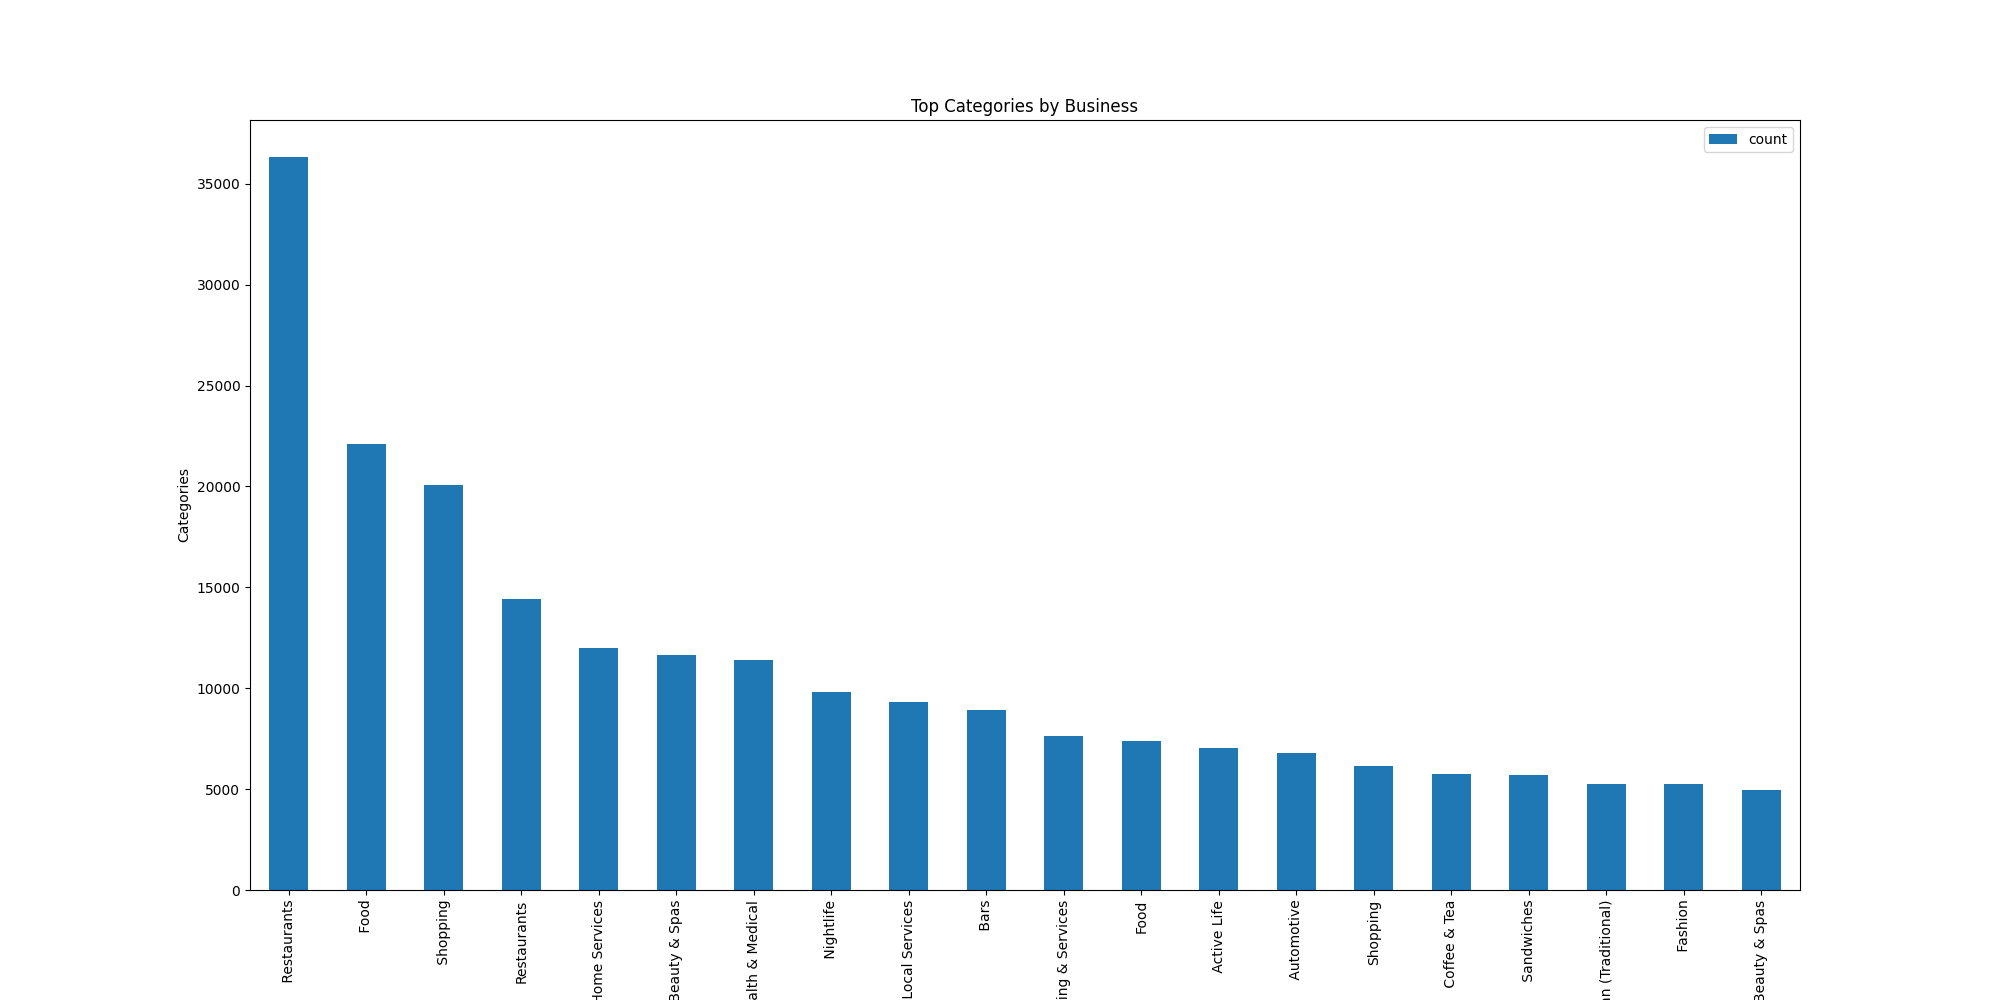

In [14]:
pdf_top20.plot(kind="bar", x="categories", figsize=(20,10))
plt.xlabel('Count')
plt.ylabel('Categories')
plt.title("Top Categories by Business")

%matplot plt

# Do Yelp Reviews Skew Negative?

Oftentimes, it is said that the only people who write a written review are those who are extremely _dissatisfied_ or extremely _satisfied_ with the service received. 

How true is this really? Let's try and answer this question.

## Loading User Data

Begin by loading the user data set from S3 and printing schema to determine what data is available.

In [15]:
df_review = spark.read.json("s3://sta9760f2021bena-spark-datasets/yelp_academic_dataset_review.json")
df_review.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- business_id: string (nullable = true)
 |-- cool: long (nullable = true)
 |-- date: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- review_id: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)

List the `business_id` and `stars` columsn together for user review data

In [18]:
df_review.select('business_id', 'stars').show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+
|         business_id|stars|
+--------------------+-----+
|buF9druCkbuXLX526...|  4.0|
|RA4V8pr014UyUbDvI...|  4.0|
|_sS2LBIGNT5NQb6PD...|  5.0|
|0AzLzHfOJgL7ROwhd...|  2.0|
|8zehGz9jnxPqXtOc7...|  4.0|
+--------------------+-----+
only showing top 5 rows

Now, let's aggregate along the `stars` column to get a resultant dataframe that displays _average stars_ per business as accumulated by users who **took the time to submit a written review**.

In [19]:
from pyspark.sql.functions import col, mean

df_review_avg = df_review \
.select('business_id', 'stars') \
.withColumn('stars', col('stars').cast('Integer')) \
.groupBy('business_id') \
.agg(mean('stars').alias('avg_stars'))

df_review_avg.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----------------+
|         business_id|        avg_stars|
+--------------------+-----------------+
|yHtuNAlYKtRZniO8O...|4.714285714285714|
|R0IJhEI-zSJpYT1YN...|3.606060606060606|
|uEUweopM30lHcVxjO...|              3.0|
|L3WCfeVozu5etMhz4...|              4.2|
|XzXcpPCb8Y5huklEN...|4.666666666666667|
+--------------------+-----------------+
only showing top 5 rows

Now the fun part - let's join our two dataframes (reviews and business data) by `business_id`. 

In [21]:
df_review_business = df_review_avg.join(df_business, df_review_avg.business_id == df_business.business_id, "inner") \
.select('avg_stars','stars','name', 'city', 'state')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Let's see a few of these:

In [22]:
df_review_business.show(5, truncate=False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------------+-----+----------------------+----------+-----+
|avg_stars         |stars|name                  |city      |state|
+------------------+-----+----------------------+----------+-----+
|5.0               |5.0  |CheraBella Salon      |Peabody   |MA   |
|3.875             |4.0  |Mezcal Cantina & Grill|Columbus  |OH   |
|3.8666666666666667|4.0  |Red Table Coffee      |Austin    |TX   |
|5.0               |5.0  |WonderWell            |Austin    |TX   |
|3.375             |3.5  |Avalon Oaks           |Wilmington|MA   |
+------------------+-----+----------------------+----------+-----+
only showing top 5 rows

Compute a new dataframe that calculates what we will call the _skew_ (for lack of a better word) between the avg stars accumulated from written reviews and the _actual_ star rating of a business (ie: the average of stars given by reviewers who wrote an actual review **and** reviewers who just provided a star rating).

The formula you can use is something like:

```
(row['avg(stars)'] - row['stars']) / row['stars']
```

If the **skew** is negative, we can interpret that to be: reviewers who left a written response were more dissatisfied than normal. If **skew** is positive, we can interpret that to be: reviewers who left a written response were more satisfied than normal.

In [30]:
df_review_skew = df_review_business \
.withColumn('skew', (df_review_business.avg_stars - df_review_business.stars)/df_review_business.stars) \
.select('skew')

pdf2 = df_review_skew.toPandas()
pdf2

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

            skew
0       0.008547
1      -0.053571
2       0.000000
3       0.037037
4      -0.037037
...          ...
160580  0.250000
160581  0.000000
160582  0.000000
160583 -0.042105
160584  0.009524

[160585 rows x 1 columns]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

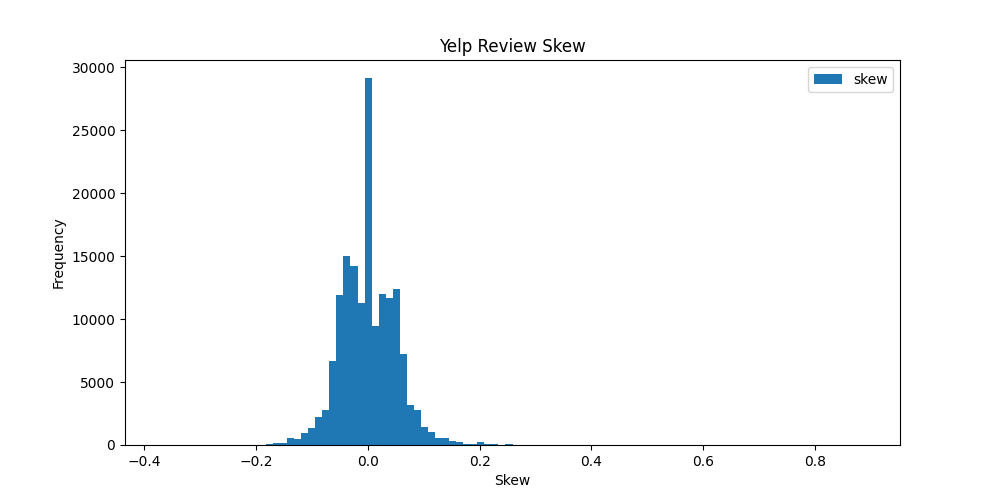

In [39]:
pdf2.plot(kind="hist",bins=100, figsize=(10,5))
plt.xlabel('Skew')
plt.ylabel('Frequency')
plt.title("Yelp Review Skew")

%matplot plt

__So, do Yelp (written) Reviews skew negative? Does this analysis actually prove anything? Expound on implications / interpretations of this graph.__

General, the graph doesn't show a negative or positive skew. Instead, it looks like the distribution of reviews fit the normal distribution curve quite well. 

In fact, we can see that there is a zero skew for majority of reviews, which means there are many reviewers who are just as satisfied as the reviews left on the Yelp business page.

# Should the Elite be Trusted? (Or, some other analysis of your choice)

For the final portion - you have a choice:

* Try and analyze some interesting dimension to this data. The **ONLY** requirement is that you must use the **Users** dataset and join on either the **business* or **reviews** dataset
* Or, you may try and answer the question posed: how accurate or close are the ratings of an "elite" user (check Users table schema) vs the actual business rating.

Feel free to use any and all methodologies at your disposal - only requirement is you must render one visualization in your analysis

Start off by loading User Dataset from S3:

In [40]:
df_user = spark.read.json("s3://sta9760f2021bena-spark-datasets/yelp_academic_dataset_user.json")
df_user.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- average_stars: double (nullable = true)
 |-- compliment_cool: long (nullable = true)
 |-- compliment_cute: long (nullable = true)
 |-- compliment_funny: long (nullable = true)
 |-- compliment_hot: long (nullable = true)
 |-- compliment_list: long (nullable = true)
 |-- compliment_more: long (nullable = true)
 |-- compliment_note: long (nullable = true)
 |-- compliment_photos: long (nullable = true)
 |-- compliment_plain: long (nullable = true)
 |-- compliment_profile: long (nullable = true)
 |-- compliment_writer: long (nullable = true)
 |-- cool: long (nullable = true)
 |-- elite: string (nullable = true)
 |-- fans: long (nullable = true)
 |-- friends: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- name: string (nullable = true)
 |-- review_count: long (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)
 |-- yelping_since: string (nullable = true)

Select `user_id` and `elite` columns to see which users were elite for which years

In [41]:
df_user.select('user_id', 'elite').show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+
|             user_id|               elite|
+--------------------+--------------------+
|q_QQ5kBBwlCcbL1s4...|2006,2007,2008,20...|
|dIIKEfOgo0KqUfGQv...|2007,2008,2009,20...|
|D6ErcUnFALnCQN4b1...|           2010,2011|
|JnPIjvC0cmooNDfsa...|2009,2010,2011,20...|
|37Hc8hr3cw0iHLoPz...|      2009,2010,2011|
|n-QwITZYrXlKQRiV3...|2010,2011,2012,20...|
|eCJoZqpV1fDKJGAsX...|                    |
|cojecOwQJpsYDxnjt...|           2010,2011|
|1jXmzuIFKxTnEnR0p...|2010,2011,2012,20...|
|-8QoOIfvwwxJ4sY20...|2012,2013,2014,20...|
|EtofuImujQBSo02xa...|           2009,2010|
|cxS6dbjyPgPS1S890...|                    |
|MUzkXfPS9JaMgJ907...|2010,2012,2013,20...|
|tjwblGkWN9m0vsGay...|2010,2011,2012,20...|
|m-zIVssiXN4bnDFqM...|                    |
|fxqvyXlml4400Bgls...|2011,2012,2013,20...|
|9edAbpniyhHFdpAvk...| 2007,2008,2009,2010|
|wURnB9fRNGAli13yB...| 2009,2010,2011,2012|
|l4P65LXNBnJqI7oTX...|2008,2009,2010,20...|
|9RIXlhUb_xEVuc_o0...|          

Create an Association Table so we can break out the years where an user was elite

In [54]:
from pyspark.sql.functions import explode, split

df_user_exploded = df_user.withColumn("elite", explode(split("elite",",")))
df_user_exploded.select("user_id", "elite")
df_user_exploded_grouped = df_user_exploded.groupby('elite')
df_user_exploded_grouped.count().orderBy('count', ascending=False).show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----+-------+
|elite|  count|
+-----+-------+
|     |2094043|
|   20|  84038|
| 2019|  47631|
| 2018|  44955|
| 2017|  39659|
| 2016|  32770|
| 2015|  27238|
| 2014|  20856|
| 2013|  18416|
| 2012|  17679|
| 2011|  12832|
| 2010|  10504|
| 2009|   6806|
| 2008|   4091|
| 2007|   2606|
| 2006|   1013|
+-----+-------+

Since 2019 looks like it has the most reviews made by elite users and the most recent year, we'll focus on that year only to get more accurate and present analysis results.

In [67]:
df_user_2019 = df_user_exploded.filter(df_user_exploded.elite == '2019') \
.select(col('user_id').alias('user_id1'), 'elite')
df_user_2019.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- user_id1: string (nullable = true)
 |-- elite: string (nullable = true)

Now we join this new dataframe to the Reviews dataframe using `user_id`. To ensure that we only join information from the Reviews dataframe that matches the `user_id` from our new dataframe, we use `LEFT JOIN`.

In [70]:
df_user_review = df_user_2019.join(df_review, df_user_2019.user_id1 == df_review.user_id, "left") \
.select(col('business_id').alias('business_id1'), 'stars', 'user_id')
df_user_review.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- business_id1: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- user_id: string (nullable = true)

Now we join this dataframe to our previously created Business-Average Stars dataframe so we can compare the Elite user's star rating to the business' average star rating

In [75]:
df_user_review2 = df_user_review.join(df_review_avg, df_user_review.business_id1 == df_review_avg.business_id, "left") \
.select('user_id','stars', 'business_id', 'avg_stars')
df_user_review2.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+--------------------+------------------+
|             user_id|stars|         business_id|         avg_stars|
+--------------------+-----+--------------------+------------------+
|jWi0LzO0jRpr6TMwo...|  5.0|--JuLhLvq3gyjNnXT...|               5.0|
|wEp-ZgJ6XpETVo1rs...|  5.0|--_nBudPOb1lNRgKf...|             3.875|
|VatcQtdb5tlz4D-N6...|  4.0|--_nBudPOb1lNRgKf...|             3.875|
|RqOHkhgZPjXQmeEL8...|  5.0|--kyOk0waSrCDlbSv...|3.8666666666666667|
|8XlB-J73QOFV91Y0e...|  4.0|--kyOk0waSrCDlbSv...|3.8666666666666667|
+--------------------+-----+--------------------+------------------+
only showing top 5 rows

Similar to our previous analysis comparing Yelp reviews to the business' average ratings, we calculate a skew column based on the Elite User's rating using the same formula:

```
(row['avg(stars)'] - row['stars']) / row['stars']
```

If the **skew** is negative, we can interpret that to be: the Elite user rated the business lower than the general crowd. If **skew** is positive, we can interpret that to be: the Elite user rated the business higher than the general crowd.


In [76]:
df_review_skew2 = df_user_review2 \
.withColumn('skew', (df_user_review2.avg_stars - df_user_review2.stars)/df_user_review2.stars) \
.select('skew')

pdf3 = df_review_skew2.toPandas()
pdf3

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

             skew
0        0.000000
1       -0.225000
2       -0.031250
3       -0.226667
4       -0.033333
...           ...
1137898 -0.216000
1137899  0.546053
1137900 -0.381579
1137901 -0.381579
1137902  0.053977

[1137903 rows x 1 columns]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

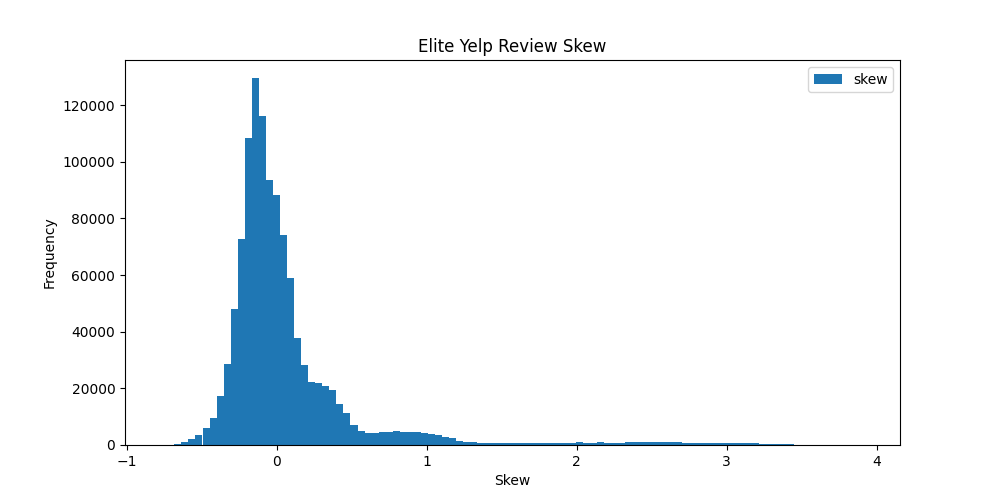

In [77]:
pdf3.plot(kind="hist",bins=100, figsize=(10,5))
plt.xlabel('Skew')
plt.ylabel('Frequency')
plt.title("Elite Yelp Review Skew")

%matplot plt

From our graph, we can see that there actually is a skew this time when comparing Elite Yelp reviews to the business' average rating. The graph has a negative skew, which means Elite Yelp ratings tend to be lower than the average yelp rating. 

What could this mean? One conclusion we can draw from this can be that Elite Yelp Users gain their status by being foodies and critics, so their standards are usually higher than the average person. Therefore, it's harder to please an Elite Yelp user and service or food that are generally satisfying to the regular consumer can not be up to the Elite Yelp user's standards.